<a href="https://colab.research.google.com/github/vinhpeters/tf-exam/blob/main/04_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

In [1]:
import zipfile

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-04-07 13:54:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   138MB/s    in 1.2s    

2023-04-07 13:54:13 (138 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [3]:
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [4]:
import os

for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 10 director

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size= IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_datagen.flow_from_directory(train_dir, target_size= IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')


Found 750 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


## Callbacks

### TensorBoard callback

In [6]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name+'/'+experiment_name+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard logs to: {log_dir}')
  return tensorboard_callback



### Tensorflow Hub

In [7]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [8]:
import tensorflow_hub as hub
from tensorflow.keras import layers


In [9]:
def create_model(model_url, num_classes=10):
  '''
  Takes a Tensorflow Hub URL and creates a
  Keras Sequential model with it.
  '''
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, name='feature_extractor_layer', input_shape=(IMAGE_SHAPE+(3,)))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model





In [10]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
resnet_model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [13]:
resnet_history=resnet_model.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                 experiment_name='resnet50v2')])

Saving TensorBoard logs to: tensorflow_hub/resnet50v220230407-135428
Epoch 1/5
24/24 [==============================] - 23s 483ms/step - loss: 1.9529 - accuracy: 0.3560 - val_loss: 1.1018 - val_accuracy: 0.6853
Epoch 2/5
24/24 [==============================] - 8s 321ms/step - loss: 0.8932 - accuracy: 0.7467 - val_loss: 0.6936 - val_accuracy: 0.7933
Epoch 3/5
24/24 [==============================] - 8s 347ms/step - loss: 0.6211 - accuracy: 0.8347 - val_loss: 0.4982 - val_accuracy: 0.8773
Epoch 4/5
24/24 [==============================] - 14s 607ms/step - loss: 0.4841 - accuracy: 0.8760 - val_loss: 0.3942 - val_accuracy: 0.9067
Epoch 5/5
24/24 [==============================] - 9s 375ms/step - loss: 0.3883 - accuracy: 0.8987 - val_loss: 0.3271 - val_accuracy: 0.9320


In [14]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  '''
  Returns seperate loss curves for training and validation metrics
  '''

  loss = history.history['loss']
  accuracy = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs=range(len(history.history['loss']))

  plt.plot(epochs,loss, label='training_loss')
  plt.plot(epochs,val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs,val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()


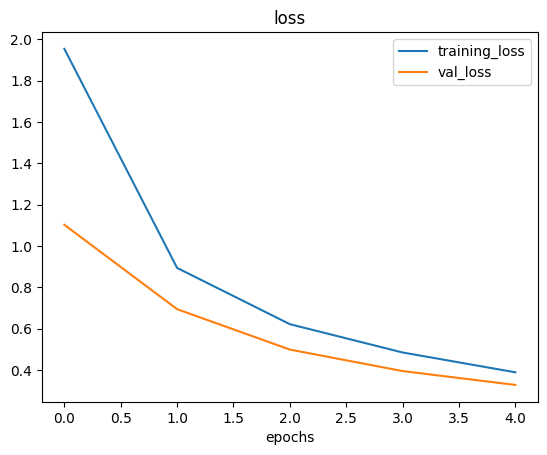

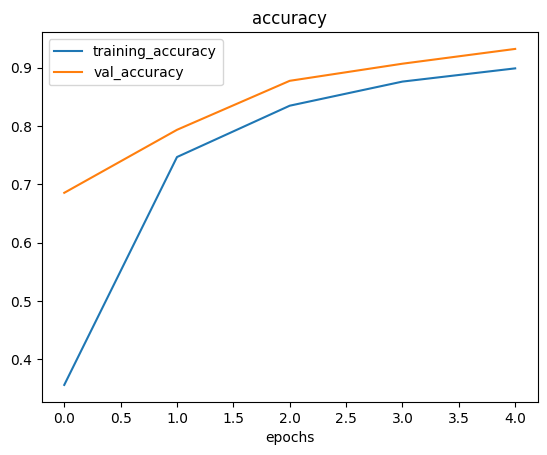

In [15]:
plot_loss_curves(history=resnet_history)

In [16]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [17]:
efficientnet_model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [18]:
efficientnet_model_history=efficientnet_model.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                 experiment_name='efficientnet')])

Saving TensorBoard logs to: tensorflow_hub/efficientnet20230407-135540
Epoch 1/5
24/24 [==============================] - 20s 402ms/step - loss: 1.8451 - accuracy: 0.4200 - val_loss: 1.2718 - val_accuracy: 0.7453
Epoch 2/5
24/24 [==============================] - 8s 340ms/step - loss: 1.0529 - accuracy: 0.7827 - val_loss: 0.8317 - val_accuracy: 0.8187
Epoch 3/5
24/24 [==============================] - 7s 306ms/step - loss: 0.7508 - accuracy: 0.8293 - val_loss: 0.6398 - val_accuracy: 0.8640
Epoch 4/5
24/24 [==============================] - 8s 354ms/step - loss: 0.5997 - accuracy: 0.8707 - val_loss: 0.5299 - val_accuracy: 0.8920
Epoch 5/5
24/24 [==============================] - 8s 338ms/step - loss: 0.5072 - accuracy: 0.8960 - val_loss: 0.4538 - val_accuracy: 0.9120


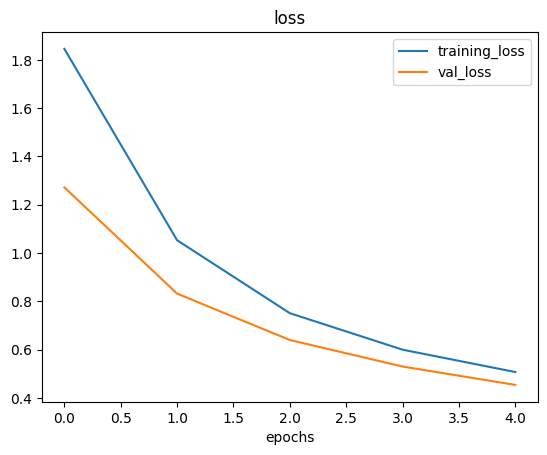

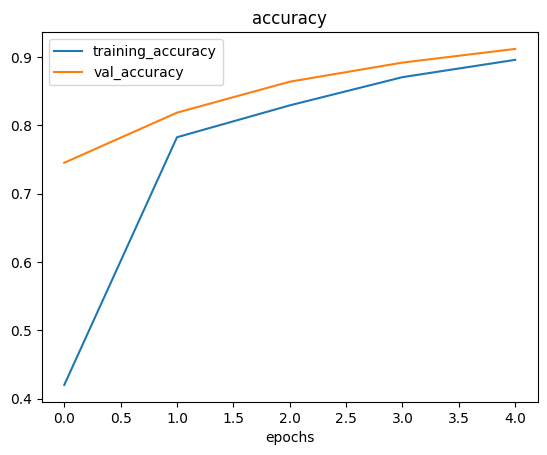

In [19]:
plot_loss_curves(history=efficientnet_model_history)

In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [23]:
len(efficientnet_model.layers[0].weights)

309

## Comparing models with TensorBoard

In [24]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB0 vs. ResNet50V2' \
  --description 'Comparing EfficientNet and ResNet feature extraction models on Food 101 subset'

2023-04-07 14:11:07.541712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   MWN-TQL-NYG


Upload started and will continue reading any new data as it's added to the lo

In [ ]:
tensorboard_dev_url = 'https://tensorboard.dev/experiment/NeCj0CWIRKCZxrv33PreyA/'

In [25]:
!tensorboard dev list

2023-04-07 14:16:22.055792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/NeCj0CWIRKCZxrv33PreyA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing EfficientNet and ResNet feature extraction models on Food 101 subset
	Id                   NeCj0CWIRKCZxrv33PreyA
	Created              2023-04-07 14:11:42 (4 minutes ago)
	Updated              2023-04-07 14:11:51 (4 minutes ago)
	Runs                 16
	Tags                 5
	Scalars              216
	Tensor bytes         0
	Binary object bytes  18513066
Total: 1 experiment(s)


In [26]:
!tensorboard dev delete --experiment_id NeCj0CWIRKCZxrv33PreyA

2023-04-07 14:17:00.161752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment NeCj0CWIRKCZxrv33PreyA.
